In [1]:
import pandas as pd
import janitor as jn
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Darwin's Finches

A research group has taken measurements of the descendants of the finches that Charles Darwin observed when he postulated the theory of evolution.

We will be using Bayesian methods to analyze this data, specifically answering the question of how quantitatively different two species of birds' beaks are.

## Data Credits

The Darwin's finches datasets come from the paper, [40 years of evolution. Darwin's finches on Daphne Major Island][data]. 

One row of data has been added for pedagogical purposes.

[data]: (https://datadryad.org/resource/doi:10.5061/dryad.g6g3h). 

### Exercise

Load the data.

In [78]:
from data import load_finches_2012
df = load_finches_2012()

### Exercise

View a random sample of the data to get a feel for the structure of the dataset.

In [79]:
df.sample(5)

,band,species,blength,beak_depth,species_enc
26,19349,fortis,11.2,8.3,0
66,19874,fortis,10.7,9.4,0
82,21052,fortis,10.5,8.5,0
201,21040,scandens,14.1,9.8,1
24,19288,fortis,11.5,9.1,0


**Note:** I have added one row of data, simulating the discovery of an "unknown" species of finch for which beak measurements have been taken.

For pedagogical brevity, we will analyze only beak depth during the class. However, I would encourage you to perform a similar analysis for beak length as well.

In [80]:
# These are filters that we can use later on.
fortis_filter = df['species'] == 'fortis'
scandens_filter = df['species'] == 'scandens'
unknown_filter = df['species'] == 'unknown'

In [5]:
with pm.Model() as beak_depth_model:
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean = pm.HalfNormal('mean', sd=100, shape=(3,))
    # Define the prior for the observed variance of the beak depths
    sd = pm.HalfCauchy('sd', beta=100, shape=(3,))
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu,
                       mu=mean[df['species_enc']], 
                       sd=sd[df['species_enc']], 
                       observed=df['beak_depth'])

### Exercise

Perform MCMC sampling to estimate the posterior distribution of each parameter.

In [6]:
with beak_depth_model:
    trace = pm.sample(2000, tuning=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, sd_log__, mean_log__]
100%|██████████| 2500/2500 [00:19<00:00, 127.40it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


### Exercise

Diagnose whether the sampling has converged or not using trace plots.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c18186048>,
      dtype=object)

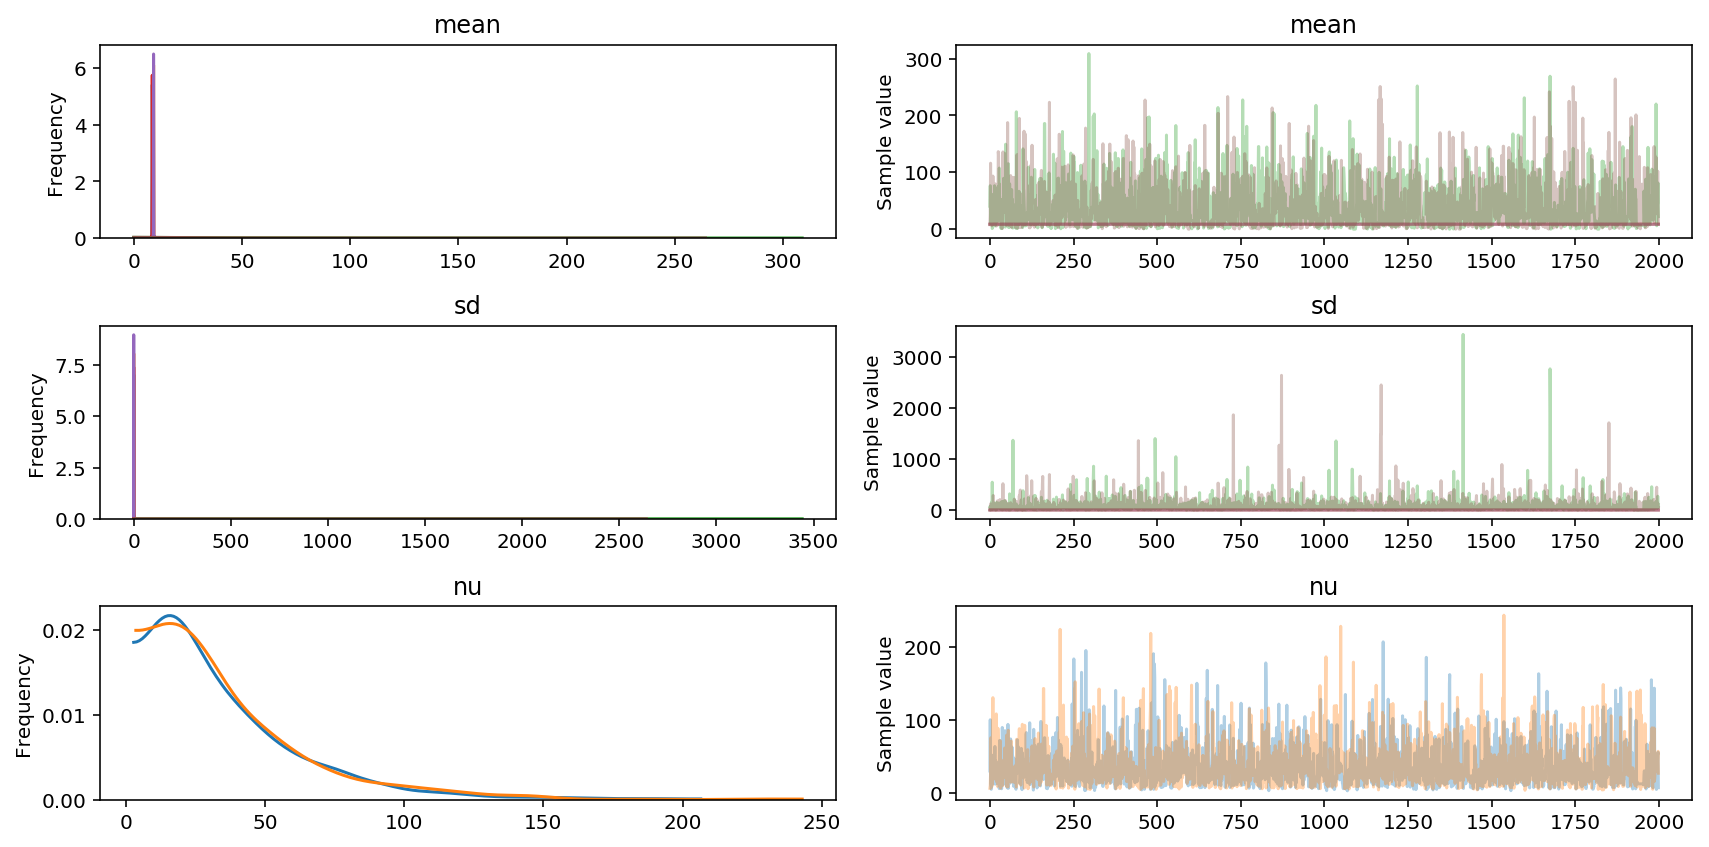

In [9]:
pm.traceplot(trace)

### Exercise

Visualize the posterior distribution over the parameters using the forest plot.

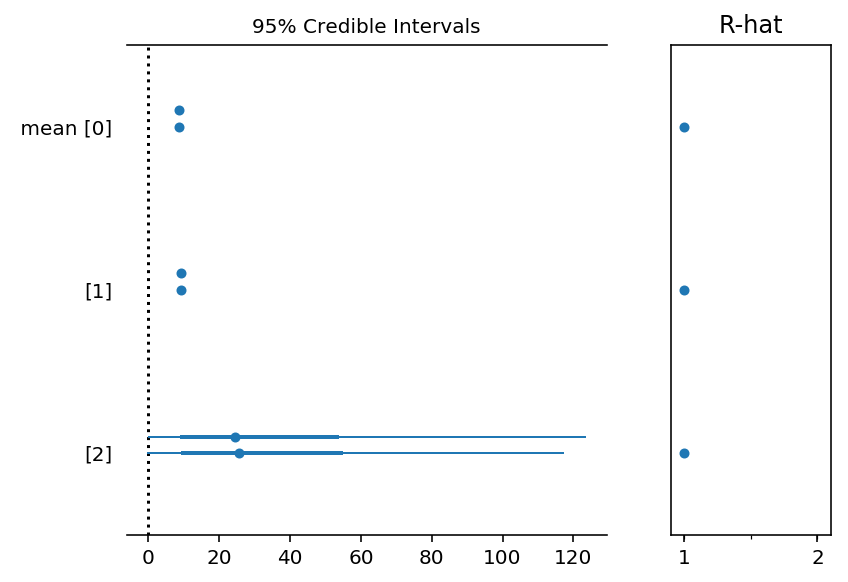

In [7]:
pm.forestplot(trace, varnames=['mean'])

### Exercise

Visualize the posterior distribution of the means. 

Text(0.5,1,'unknown')

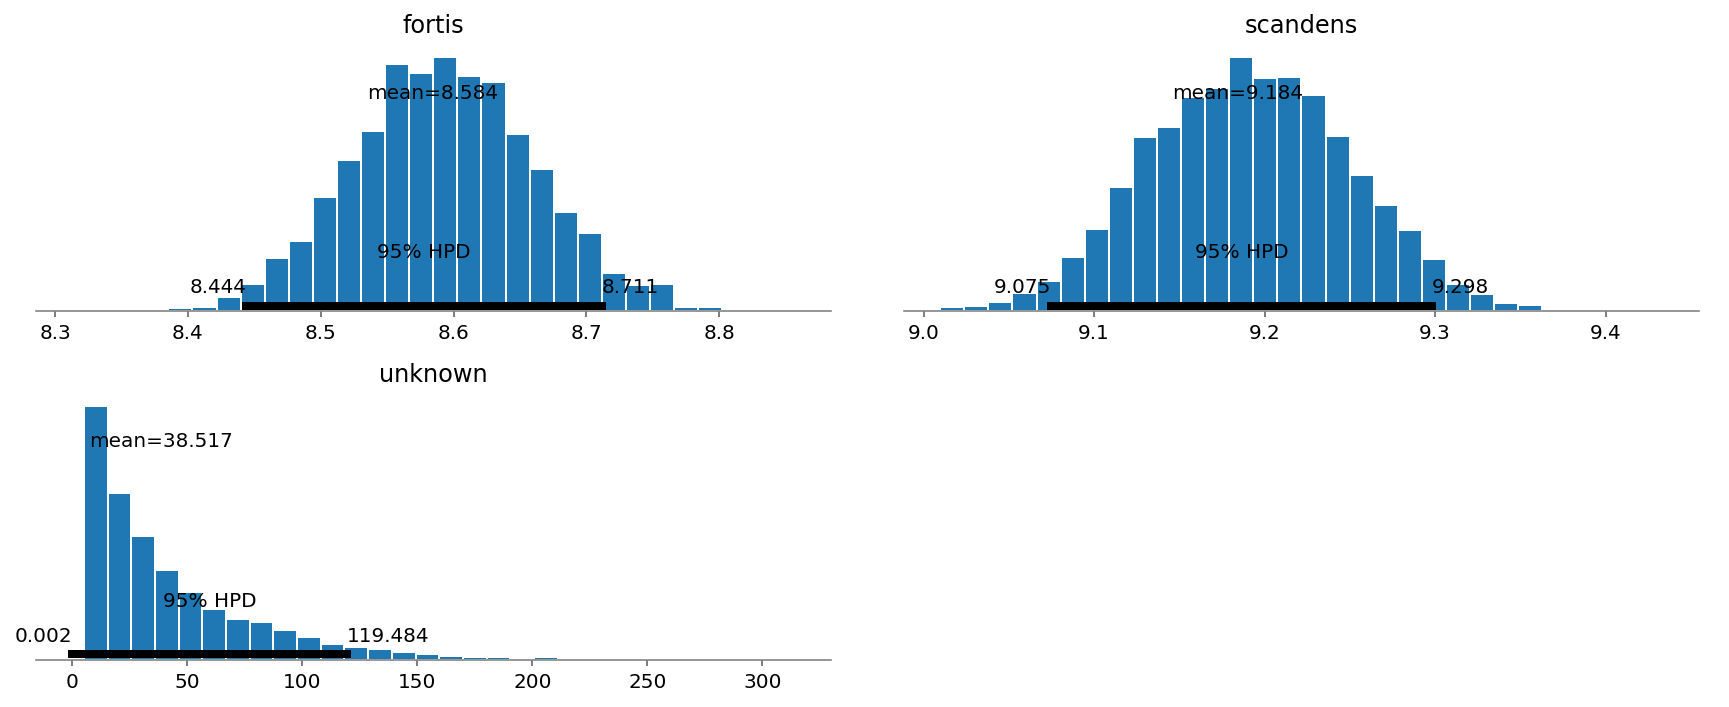

In [82]:
ax1, ax2, ax3 = pm.plot_posterior(trace, varnames=['mean'])
ax1.set_title('fortis')
ax2.set_title('scandens')
ax3.set_title('unknown')

### Discuss

- Is the posterior distribution of beaks for the unknown species reasonable?

### Exericse

Perform a posterior predictive check to visually diagnose whether the model describes the data generating process well or not.

In [50]:
samples = pm.sample_ppc(trace, model=beak_depth_model, samples=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1249.50it/s]


Hint: Each column in the samples (key: "likelihood") corresponds to simulated measurements of each finch in the dataset. We can use fancy indexing along the columns (axis 1) to select out simulated measurements for each category, and then flatten the resultant array to get the full estimated distribution of values for each class.

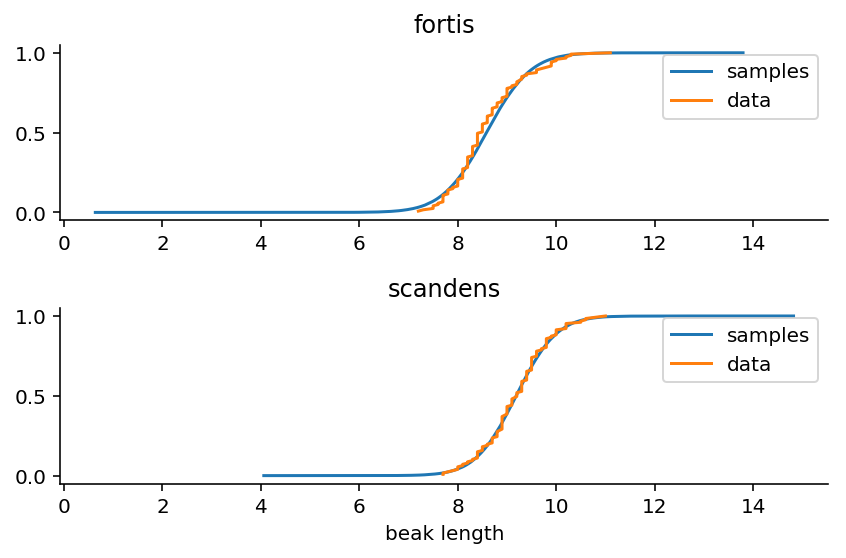

In [76]:
fig = plt.figure()
ax_fortis = fig.add_subplot(2, 1, 1)
ax_scandens = fig.add_subplot(2, 1, 2, sharex=ax_fortis)

# Extract just the fortis samples.
fortis_samples = samples['likelihood'][:, df[fortis_filter].index].flatten()
# Compute the ECDF for the fortis samples.
x_s, y_s = ecdf(fortis_samples)
ax_fortis.plot(x_s, y_s, label='samples')

# Extract just the fortis measurements.
fortis_data = df[fortis_filter]['beak_depth']
# Compute the ECDF for the fortis samples
x, y = ecdf(fortis_data)
ax_fortis.plot(x, y, label='data')

ax_fortis.legend()
ax_fortis.set_title('fortis')

# Extract just the scandens samples.
scandens_samples = samples['likelihood'][:, df[scandens_filter].index].flatten()
# Compute the ECDF for the scandens samples
x_s, y_s = ecdf(scandens_samples)
ax_scandens.plot(x_s, y_s, label='samples')

# Extract just the scandens measurements.
scandens_data = df[scandens_filter]['beak_depth']
# Compute the ECDF for the scanens samples
x, y = ecdf(scandens_data)

ax_scandens.plot(x, y, label='data')
ax_scandens.legend()
ax_scandens.set_title('scandens')
ax_scandens.set_xlabel('beak length')

sns.despine()
plt.tight_layout()

## Summary

1. NumPy-like fancy indexing lets us write models in a concise fashion.
1. Posterior estimates can show up as being "unreasonable", "absurd", or at the minimum, counter-intuitive, if we do not impose the right set of assumptions on the model.
